In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Fit original data

In [2]:
data_t0 = pd.read_csv('data/starships_slice_init.csv', index_col='id', parse_dates=['date'])

In [3]:
# Compute stats for number of ships counted over time
counts_along_time = data_t0.groupby(['ship_type', 'date']).count()['lon']
counts_stats = counts_along_time.groupby('ship_type').describe()

In [4]:
# Add boundaries
counts_stats['bound_max'] = counts_stats['mean'] + 3 * counts_stats['std']
counts_stats['bound_min'] = counts_stats['mean'] - 3 * counts_stats['std']
counts_stats

,count,mean,std,min,25%,50%,75%,max,bound_max,bound_min
ship_type,,,,,,,,,,
Civilian Star Shuttle,13.0,1.538462,0.776250,1.0,1.0,1.0,2.0,3.0,3.867212,-0.790289
Imperial SpaceShuttle,17.0,10.941176,0.555719,10.0,11.0,11.0,11.0,12.0,12.608333,9.274020
TIE Fighter,17.0,21.529412,0.717430,21.0,21.0,21.0,22.0,23.0,23.681702,19.377122
TIE bomber,17.0,6.882353,0.332106,6.0,7.0,7.0,7.0,7.0,7.878670,5.886036


## Detect breaches

In [5]:
# Load new dataa
#data = pd.read_csv('data/starships_slice_new_1.csv', index_col='id', parse_dates=['date'])

# Filter specific date
DATE_MIN = '2020-01-01'
DATE_MAX = '2020-10-01'
data_t1 = pd.read_csv('data/starships_clean.csv', index_col='id', parse_dates=['date'])
ma_min = data_t1['date'] > DATE_MIN
ma_max = data_t1['date'] < DATE_MAX
data = data_t1[ma_min & ma_max]

In [6]:
# Keep only ship types present in both snaps
# /!\ Will not consider the droids if not on both snaps!
ship_types_0 = data_t0['ship_type'].unique()
ship_types_1 = data_t1['ship_type'].unique()
ship_types = [s_type for s_type in ship_types_0 if s_type in ship_types_1]

In [7]:
counts_along_time = data_t1.groupby(['ship_type', 'date']).count()['lon']

In [8]:
# Record outliers
break_max = {}
break_min = {}

for ship in ship_types:
    ma_ship_break_max = counts_along_time.loc[ship] > (counts_stats['bound_max'].loc[ship])
    ship_break_max = counts_along_time[ship][ma_ship_break_max]
    break_max[ship] = ship_break_max

    ma_ship_break_min = counts_along_time.loc[ship] < (counts_stats['bound_min'].loc[ship])
    ship_break_min = counts_along_time[ship][ma_ship_break_min]
    break_min[ship] = ship_break_min

In [9]:
break_max

{'TIE Fighter': date
 2020-02-06 12:00:00    27
 2020-02-22 12:00:00    37
 2020-02-25 12:00:00    37
 2020-02-28 12:00:00    37
 2020-03-07 12:00:00    37
 2020-03-15 12:00:00    36
 2020-03-27 12:00:00    36
 2020-04-22 12:00:00    37
 2020-05-01 12:00:00    38
 2020-05-09 12:00:00    38
 2020-05-30 12:00:00    37
 2020-06-07 12:00:00    38
 2020-07-09 12:00:00    37
 2020-07-21 12:00:00    36
 2020-10-13 12:00:00    36
 2020-10-16 12:00:00    37
 2020-10-30 12:00:00    39
 2020-12-09 12:00:00    36
 2020-12-29 12:00:00    37
 2021-01-07 12:00:00    38
 2021-01-19 12:00:00    38
 2021-02-10 12:00:00    36
 2021-02-20 12:00:00    38
 2021-02-28 12:00:00    39
 2021-03-07 12:00:00    37
 2021-03-20 12:00:00    38
 2021-04-02 12:00:00    38
 2021-04-16 12:00:00    39
 2021-04-28 12:00:00    38
 Name: lon, dtype: int64,
 'TIE bomber': Series([], Name: lon, dtype: int64),
 'Imperial SpaceShuttle': date
 2020-05-09 12:00:00    13
 2020-10-30 12:00:00    13
 2021-03-07 12:00:00    13
 2021-

In [10]:
break_min

{'TIE Fighter': Series([], Name: lon, dtype: int64),
 'TIE bomber': date
 2019-07-31 12:00:00    5
 Name: lon, dtype: int64,
 'Imperial SpaceShuttle': date
 2019-04-27 12:00:00    9
 2020-02-25 12:00:00    9
 Name: lon, dtype: int64,
 'Civilian Star Shuttle': Series([], Name: lon, dtype: int64)}

In [11]:
ship_types

['TIE Fighter', 'TIE bomber', 'Imperial SpaceShuttle', 'Civilian Star Shuttle']

In [12]:
data_t1['ship_type'].value_counts()

TIE Fighter              2034
Imperial SpaceShuttle     827
TIE bomber                511
Civilian Star Shuttle      89
Surveillance droid          2
Name: ship_type, dtype: int64

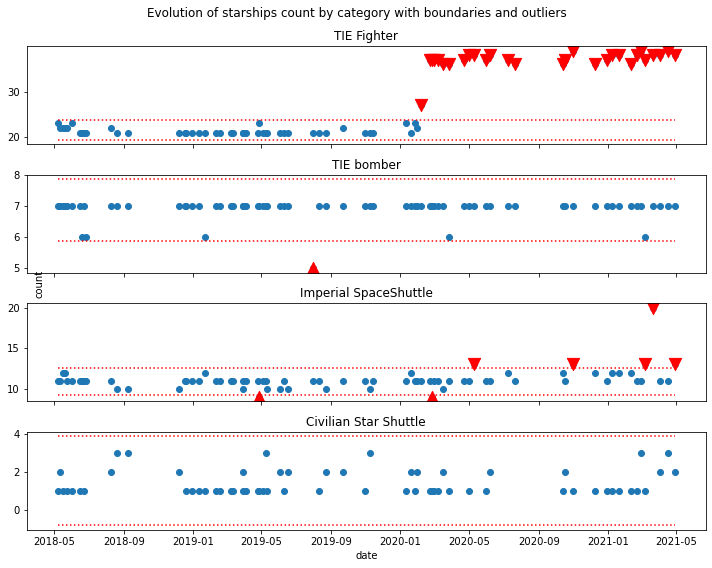

In [20]:
# Get the count of a ship_type for each date
series_by_type = []
fig, axs = plt.subplots(len(ship_types), 1, figsize=(10, 8), sharex=True)

date_min = data_t1['date'].min()
date_max = data_t1['date'].max()

for i, ship_type in enumerate(ship_types):
    ma_ship_type = data_t1['ship_type'] == ship_type
    evol_count = data_t1[ma_ship_type].groupby('date').count()['ship_type']
    axs[i].scatter(evol_count.index, evol_count)
    axs[i].set_title(ship_type)
    
    # Draw boundaries
    axs[i].hlines(counts_stats['bound_min'].loc[ship_type], xmin=date_min, xmax=date_max, color='r', linestyles='dotted')
    axs[i].hlines(counts_stats['bound_max'].loc[ship_type], xmin=date_min, xmax=date_max, color='r', linestyles='dotted')

    try:
        axs[i].scatter(break_max[ship_type].index, break_max[ship_type].values, color='r', s=150, marker='v')
        axs[i].scatter(break_min[ship_type].index, break_min[ship_type].values, color='r', s=150, marker='^')
    except:
        pass

plt.suptitle('Evolution of starships count by category with boundaries and outliers')
fig.text(0.06, 0.5, 'count', ha='center', va='center', rotation='vertical')
plt.xlabel('date')
# plt.tight_layout()
plt.savefig('data/figures/event_detector.pdf')